In [ ]:
# prompt: 구글 드라이브 연결

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [ ]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/특정 테스크에 해당하는 자연어처리 모델 서빙하기/mrus_data.csv')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/특정 테스크에 해당하는 자연어처리 모델 서빙하기/data.csv')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/특정 테스크에 해당하는 자연어처리 모델 서빙하기/data_resampled.csv')

In [ ]:
# 데이터셋의 결측치 확인
print(data.isnull().sum())

text      0
labels    0
dtype: int64


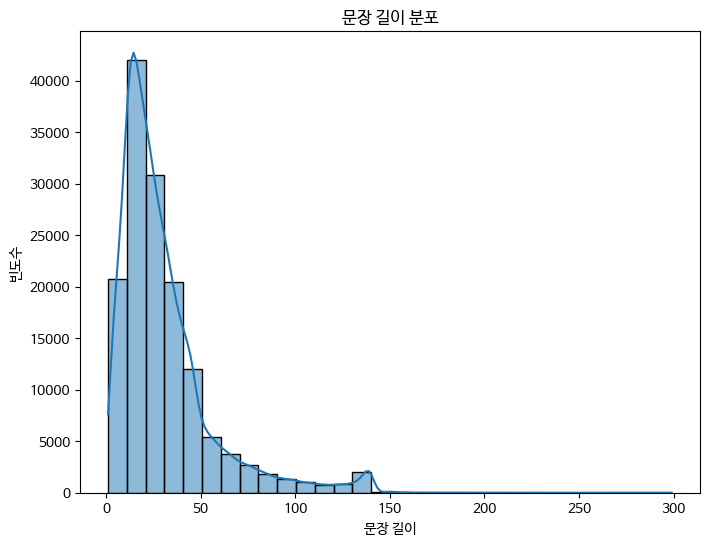

In [ ]:
# 문장 길이 계산
sentence_lengths = data['text'].apply(len)

# 문장 길이 분포 시각화
plt.figure(figsize=(8, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('문장 길이 분포')
plt.xlabel('문장 길이')
plt.ylabel('빈도수')

# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

plt.show()

In [ ]:
# 한국어 외 문자가 포함된 행 찾기
# 한국어 유니코드 범위를 벗어나는 문자를 포함하는 행을 찾습니다.
non_korean_rows = data[~data['text'].str.contains('[가-힣ㄱ-ㅎㅏ-ㅣ]', regex=True)]

# 결과 출력
non_korean_rows

,text,labels
25990,......,중립
26017,...,중립
26064,......,중립
71248,.......,긍정
71364,...,긍정
...,...,...
141844,".,.,.,.,.,,.,",부정
141895,?,부정
142290,.,부정
142548,!!!!!!!!!!!!!!!!!!!,부정


In [ ]:
# pandas의 get_dummies 함수를 사용하여 'labels' 열에 대해 원-핫 인코딩을 적용
one_hot_labels = pd.get_dummies(data['labels'], prefix='label')

# 원-핫 인코딩된 결과를 기존 데이터 프레임에 합침
data_with_one_hot = pd.concat([data, one_hot_labels], axis=1)

data_with_one_hot

,text,labels,label_긍정,label_부정,label_중립
0,서해 수자원도 한류라서 그동안 불법조업 방치했나?,부정,0,1,0
1,니가 인간이가.,부정,0,1,0
2,강아지를 때리고 유기하는것만 학대는 아닙니다!,부정,0,1,0
3,하여간 우리나라 교육엔 미래가 없어!!,부정,0,1,0
4,채널에이 군부 개인거 인증하냐 동아일보야!!,부정,0,1,0
...,...,...,...,...,...
145828,조악하다 못해 한심한,부정,0,1,0
145829,진심 내가 왠만하면 영화들 비판 안하고 다 괜찮다 하는데 평점 첨 보고 오 괜찮나?...,부정,0,1,0
145830,너무 재미있어요^-^,부정,0,1,0
145831,김수로가 열심히 할수록 짠해지는 영화.,부정,0,1,0


In [ ]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터로 분할 (여기서는 비율을 90:10으로 설정)
train_data, test_data = train_test_split(data_with_one_hot, test_size=0.1, random_state=42)

In [ ]:
len(train_data), len(test_data)

(131249, 14584)

In [ ]:
train_data['labels'].value_counts()

부정    43817
긍정    43733
중립    43699
Name: labels, dtype: int64

In [ ]:
test_data['labels'].value_counts()

중립    4912
긍정    4878
부정    4794
Name: labels, dtype: int64

In [ ]:
# 학습 데이터와 테스트 데이터에서 'labels' 열을 삭제합니다.
train_data = train_data.drop('labels', axis=1)
test_data = test_data.drop('labels', axis=1)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE   #자동으로 GPU 성능 최적화
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label_긍정'], train_data['label_부정'], train_data['label_중립']))
train_ds = train_ds.batch(batch_size).shuffle(10000).cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_data['text'], test_data['label_긍정'], test_data['label_부정'], test_data['label_중립']))
test_ds = test_ds.batch(batch_size).shuffle(10000).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for text_batch, label_batch1, label_batch2, label_batch3 in train_ds.take(1):
  for i in range(6):
    print(f'영화평: {text_batch.numpy()[i].decode("utf-8")}')
    label1 = label_batch1.numpy()[i]
    label2 = label_batch2.numpy()[i]
    label3 = label_batch3.numpy()[i]
    print(f'Label : {label1, label2, label3}')

영화평: 5년은 꼈나 보네. 너무 허옇다. 썬탠 해야겠다. 
Label : (0, 0, 1)
영화평: 진짜 디즈니 같은 영화다 영화가 이렇게 길게 느껴지긴 처음임ㅇㅇ
Label : (0, 1, 0)
영화평: 보다가 졸았음
Label : (0, 1, 0)
영화평: 별점10점줬다 안본사람한테보라고 그래
Label : (1, 0, 0)
영화평: 자살해도 안죽는 한 여인의무적을 알수있는 감동적인영화.
Label : (0, 1, 0)
영화평: 음~~~
Label : (1, 0, 0)


In [ ]:
# y1, y2, y3을 새로운 축을 따라 쌓아서 하나의 텐서로 합칩니다.
def merge_labels(x, y1, y2, y3):
    y = tf.stack([y1, y2, y3], axis=-1)
    return x, y

# 데이터셋이 (x, y1, y2, y3) 형태로 구성되어 있다고 가정하고, map 함수를 사용하여 구조를 재조정합니다.
train_ds = train_ds.map(merge_labels)
test_ds = test_ds.map(merge_labels)

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(6):
    print(f'영화평: {text_batch.numpy()[i].decode("utf-8")}')
    label = label_batch.numpy()[i]
    print(f'Label : {label}')

영화평: 봤던 영화지만 시간이 꽤 지났기에 인트로 영상을 확인해보니 이병헌의 진한 감성이 묻어난 묵직한 저음에서 울리는 사랑 이면의 이유모를 슬픔과 세상 그무엇도 아닌 한 남자의 사랑을 통해 완벽해지는 수애의 미소가 스크린을 꽉채우며 그들의 향기를 수놓더라.
Label : [1 0 0]
영화평: 한국 최고의 공포영화.
Label : [1 0 0]
영화평: 개누리당에서 가장 소신있고 민심을 따른 사람은 김용태 딱 한명 뿐이다...
Label : [0 0 1]
영화평: 감동잇고후반에약간의반전...신비로우면서도묘한감정을섬사하네요
Label : [1 0 0]
영화평: 뭐니 이게.........정말 작품성이 있는ㄱ영화라고 할수있나??????????
Label : [0 1 0]
영화평: 아닙니다.
Label : [0 0 1]


### 토크나이저 불러오기

In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [ ]:
tfhub_handle_preprocess, tfhub_handle_encoder

('https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3')

In [ ]:
# 전처리 모델 불러오기
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['최근 본 영화중에 제일 재밌는 듯']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')  # token id
print(f'Input Mask : {text_preprocessed["input_mask"]}')     # padding 여부
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')  #1st, 2nd sentence 구분

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [[  101  9764 50248  9358 42428 81724  9672 18392   100  9120   102     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
Input Mask : [[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 

In [ ]:
# encoder 모델 불러오기
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'load된 BERT 모델: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :10]}')
print()
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Encoder Outputs Shape:{len(bert_results["encoder_outputs"])}')

load된 BERT 모델: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.31967217 -0.19948578  0.21214536 -0.06687225 -0.07733947  0.31496158
  0.02227223  0.29431632 -0.4278133   0.17573954]

Sequence Outputs Shape:(1, 128, 768)
Encoder Outputs Shape:12


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #전처리 model
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  #pretrained BERT model
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  #last layer 추가
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# 모델이 아직 훈련되지 않았기 때문에 출력은 의미가 없음.
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))

print(bert_raw_result)

tf.Tensor([[0.17918615 0.23086388 0.58994997]], shape=(1, 3), dtype=float32)


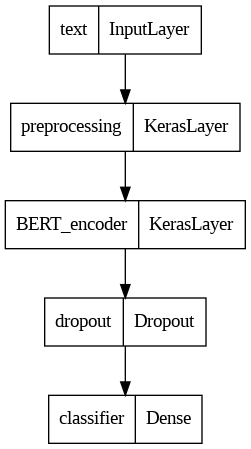

In [ ]:
tf.keras.utils.plot_model(classifier_model)

### Model Training

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
len(train_ds)

4102

In [ ]:
# 에포크 5번
epochs = 5
steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
import time
s = time.time()

print(f'Training model with {tfhub_handle_encoder}\n')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4102/4102 [==============================] - 4073s 989ms/step - loss: 0.5717 - categorical_accuracy: 0.7595 - val_loss: 0.4537 - val_categorical_accuracy: 0.8201
Epoch 2/5
4102/4102 [==============================] - 4065s 991ms/step - loss: 0.4187 - categorical_accuracy: 0.8369 - val_loss: 0.4763 - val_categorical_accuracy: 0.8285
Epoch 3/5
4102/4102 [==============================] - 4075s 993ms/step - loss: 0.3288 - categorical_accuracy: 0.8766 - val_loss: 0.5092 - val_categorical_accuracy: 0.8309
Epoch 4/5
4102/4102 [==============================] - 4075s 993ms/step - loss: 0.2577 - categorical_accuracy: 0.9071 - val_loss: 0.5744 - val_categorical_accuracy: 0.8302
Epoch 5/5
4102/4102 [==============================] - 4076s 994ms/step - loss: 0.2077 - categorical_accuracy: 0.9267 - val_loss: 0.6075 - val_categorical_accuracy: 0.8336


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
# 에포크별 정확도 그래프
acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
# 모델 저장
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/특정 테스크에 해당하는 자연어처리 모델 서빙하기/second_bert'

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
# 모델 불러오기
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
# 간단한 예측 수행
def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print(f'input : {inputs[i]}')

    # NumPy 배열로 변환
    result_array = np.array(results[i])

    # 최대값을 가지는 요소의 인덱스 찾기
    max_index = np.argmax(result_array)
    print(f'result : {class_name[max_index]}')
    print()

class_name = {0: '긍정', 1:'부정', 2:'중립'}

examples = [
     text_test[0],
    '오늘은 무난한 하루였어.',
    '진짜 너무 재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ',
    '영화가 끔찍히 재미없어서 할말을 잃음',
]

reloaded_results = reloaded_model(tf.constant(examples))
print_my_examples(examples, reloaded_results)

input : 최근 본 영화중에 제일 재밌는 듯
result : 긍정

input : 오늘은 무난한 하루였어.
result : 중립

input : 진짜 너무 재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋ
result : 긍정

input : 영화가 끔찍히 재미없어서 할말을 잃음
result : 부정

